In [30]:
import xarray as xr
from lib.bisicles_defaults import ICE_DENSITY

In [31]:
def convert_ma_to_kgm2s(smb):
    """
    Convert surface mass balance from metres of ice equivalent per annum (mm w.e. a-1)
    to kilograms per square meter per second (kg m-2 s-1).

    Parameters:
    smb (xarray.DataArray): Surface mass balance in m i.e. a-1.

    Returns:
    xarray.DataArray: Surface mass balance in kg m-2 s-1.
    """
    # Conversion factor from m i.e. a-1 to kg m-2 s-1
    seconds_per_year = 365 * 24 * 60 * 60
    conversion_factor = ICE_DENSITY / seconds_per_year
    smb_kgm2s = smb * conversion_factor
    return smb_kgm2s

def convert_kgm2s_to_ma(smb):
    seconds_per_year = 365 * 24 * 60 * 60
    conversion_factor = seconds_per_year / ICE_DENSITY
    smb_ma = smb * conversion_factor
    return smb_ma

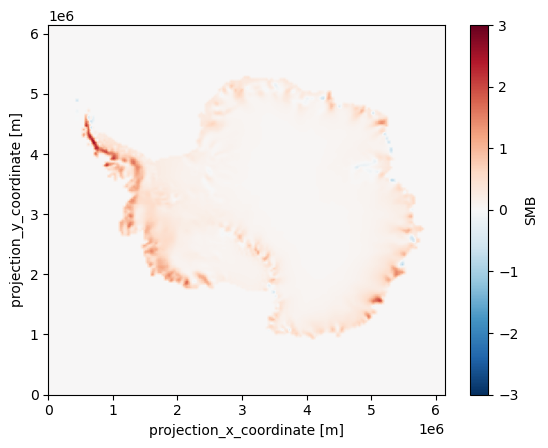

In [98]:
# MAR SMB used in the inversion
mar = xr.open_dataset('/Users/jonniebarnsley/data/MAR/antarctica.mon-SMB-MAR_ERA5-1980-2021.mean.smb.nc')
mar.SMB.plot(vmin=-3, vmax=3, cmap='RdBu_r')

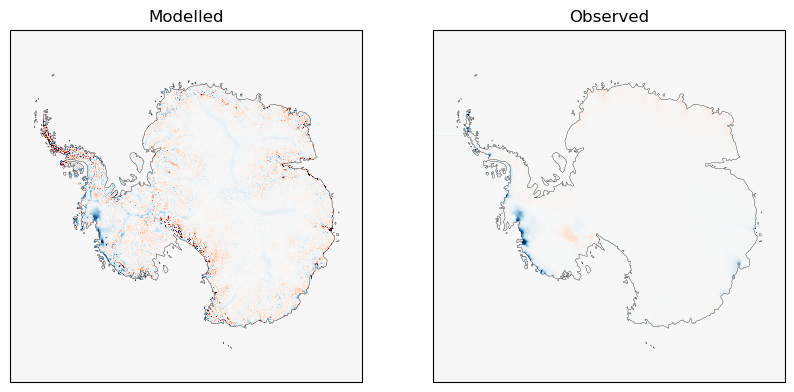

In [101]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from lib.myplots import spatial
# dHdt modelled and observed (Smith et al. 2020)
bisicles = xr.open_dataset('/Users/jonniebarnsley/Downloads/run012_inv.nc')
dhdt_mod = bisicles.dThicknessdt.isel(time=-1)
smith2020 = xr.open_dataset('/Users/jonniebarnsley/data/ICESat2/dhdt/ais_dhdt_grounded_filt_bisicles_8km.nc')
dhdt_obs = smith2020.dhdt_obs

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
#im1 = ax[0].pcolormesh(dhdt_mod, vmin=-2, vmax=2, cmap='RdBu_r')
#im2 = ax[1].pcolormesh(dhdt_obs, vmin=-2, vmax=2, cmap='RdBu_r')

im1 = spatial(ax[0], dhdt_mod, vmin=-3, vmax=3, cmap='RdBu_r')
im2 = spatial(ax[1], dhdt_obs, vmin=-3, vmax=3, cmap='RdBu_r')

ax[0].coastlines(lw=0.1, alpha=0.5)
ax[1].coastlines(lw=0.1, alpha=0.5)

ax[0].set_title('Modelled')
ax[1].set_title('Observed')

for a in ax:
    a.set_aspect('equal')

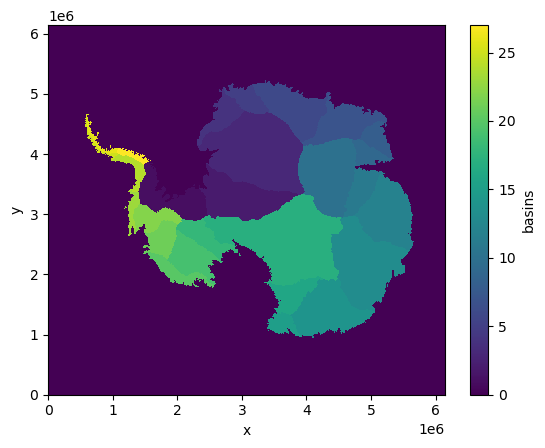

In [ ]:
# View Zwally basins
zwally = xr.open_dataset('/Users/jonniebarnsley/data/masks/zwally_basins_8km.nc')
zwally.basins.plot()

In [ ]:
# Compute the misfit between modelled and observed dHdt by basin
import numpy as np
import pandas as pd
from collections import defaultdict
basin_nums = np.unique(zwally.basins.values)

misfit_spatial = np.zeros(zwally.basins.shape)
data = defaultdict(list)

for basin in basin_nums:
    if basin == 0: # ice shelves / open ocean
        continue
    mask = zwally.basins == basin
    dhdt_mod_basin = dhdt_mod.where(mask)
    dhdt_obs_basin = dhdt_obs.where(mask)
    mar_basin = mar.SMB.where(mask)
    
    mod_mean = dhdt_mod_basin.mean().item()
    obs_mean = dhdt_obs_basin.mean().item()
    mar_mean = mar_basin.mean().item()
    misfit = obs_mean - mod_mean
    misfit_spatial = np.where(mask, misfit, misfit_spatial)

    data['Basin'].append(int(basin))
    data['Model'].append(round(mod_mean, 3))
    data['Obs'].append(round(obs_mean, 3))
    data['Misfit'].append(round(misfit, 3))
    
df = pd.DataFrame(data)
df

,Basin,Model,Obs,Misfit
0,1,-0.006,0.045,0.051
1,2,0.001,0.004,0.003
2,3,0.003,0.015,0.013
3,4,-0.002,0.047,0.049
4,5,-0.027,0.067,0.094
5,6,-0.010,0.048,0.058
6,7,0.042,0.060,0.018
7,8,0.055,0.062,0.007
8,9,0.054,0.011,-0.043
9,10,0.008,0.007,-0.001


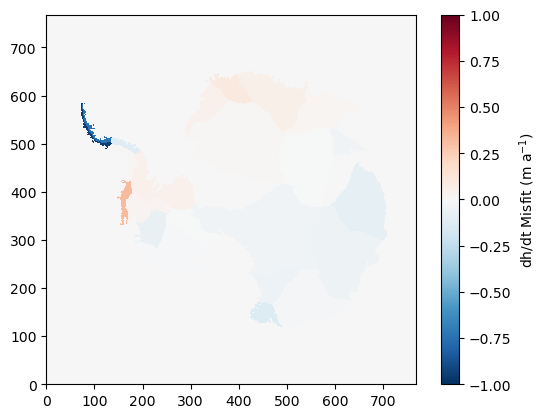

In [ ]:
# Visualise the misfit between modelled and observed dH/dt by Zwally basin
plt.pcolormesh(misfit_spatial, cmap='RdBu_r', vmin=-1, vmax=1)
plt.gca().set_aspect('equal')
plt.colorbar(label='dh/dt Misfit (m a$^{-1}$)')

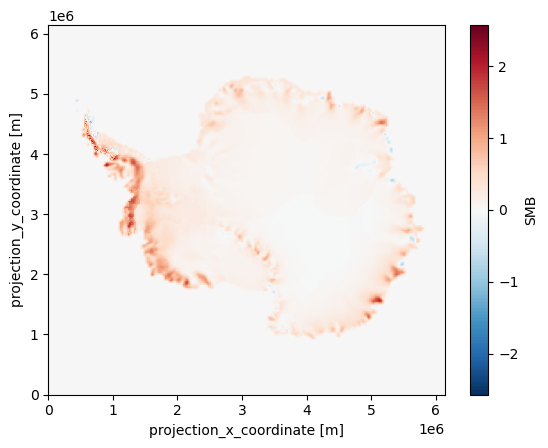

In [123]:
# Adjust MAR to account fo bias between modelled and observed dHdt
bias_adjusted = mar.SMB + np.nan_to_num(misfit_spatial, 0)
bias_adjusted.plot()

In [124]:
ds = xr.Dataset({'smb': bias_adjusted})
ds.to_netcdf('/Users/jonniebarnsley/data/smb_bias_adjusted_run012.nc')

In [122]:
np.nan_to_num(misfit_spatial, 0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])